In [ ]:
!pip install -q jax==0.2.11 #jaxlib==0.1.64

     |████████████████████████████████| 604kB 4.2MB/s 


In [ ]:
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random

In [ ]:
# for model stuff
import jax.experimental.optimizers as optimizers
import jax.experimental.stax as stax
from jax import jit

import jax
import jax.numpy as np

In [ ]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [ ]:
!pip install -q IMNN 

     |████████████████████████████████| 133kB 4.4MB/s 
     |████████████████████████████████| 81kB 5.5MB/s 


In [ ]:
pip uninstall tensorflow -y -q

In [ ]:
pip install -Uq tfp-nightly[jax] > /dev/null

In [ ]:
pip install -q tensorflow

     |████████████████████████████████| 454.3MB 31kB/s 


In [ ]:
pip install -q jax-cosmo

     |████████████████████████████████| 286kB 4.4MB/s 


In [ ]:
import jax
print("jax version: ", jax.__version__)
import jax.numpy as np
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz

rng = jax.random.PRNGKey(2)

import seaborn as sns
sns.set()

jax version:  0.2.11


In [ ]:
# for model stuff
import jax.experimental.optimizers as optimizers
import jax.experimental.stax as stax
from jax import jit

# for imnn
import imnn
import imnn.lfi

#import jax_cosmo as jc
import matplotlib.pyplot as plt
import tensorflow_probability
tfp = tensorflow_probability.substrates.jax
rng = jax.random.PRNGKey(0)

In [ ]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [ ]:
N=20

In [ ]:
def scipy_compute_r2(N):
    _Di = np.tile(toeplitz(np.arange(N)), (N, N))
    _Dj = np.concatenate(
        [np.concatenate(
            [np.tile(np.abs(i - j),(N, N)) 
             for i in range(N)], 
            axis=0)
         for j in range(N)],
        axis=1)
    _distance_squared = _Di * _Di + _Dj * _Dj
    return _distance_squared

def compute_r2(N):
    _r2 = np.tile(np.abs(np.expand_dims(np.arange(N), 0) 
                    - np.expand_dims(np.arange(N), 1)), (N, N)) ** 2. + np.abs(np.expand_dims(np.repeat(np.arange(N), N), 0) 
                             - np.expand_dims(np.repeat(np.arange(N), N), 1)) ** 2.
    return _r2

r2 = compute_r2(N).astype(np.float32)

def ξ_G(β):
    return np.exp(
        -np.expand_dims(r2, tuple(np.arange(β.ndim))) 
        / 4. / np.expand_dims(β, (-2, -1))**2.)

def get_G_field(β):
    pass

def fill_zeros(k, value):
    from functools import partial

    def fnk(k):
        return jax.lax.cond(np.less_equal(k, 1e-5), lambda _: value, lambda k: k+value, operand=k)

    if len(k.shape) == 1:
        return jax.vmap(fnk)(k)
    else:
        return jax.vmap(partial(fill_zeros, value=value))(k)


def xi_LN(r, α, β, PixelNoise=0.01):

    xi = 1/(np.power(α+1e-12,2)) * (np.exp(np.power(α,2)*np.exp(-0.25*np.power(r/β,2))) - 1)

    # Add pixel noise at zero separation:

    xi = fill_zeros(xi, PixelNoise**2)
    #xi[np.where(r<1e-5)] += PixelNoise**2

    return xi

In [ ]:
def dxi_LN_dalpha(r, α, β):

    _deriv =  2/(α+1e-12) * np.exp(-0.25*np.power(r/β,2)) * np.exp(np.power(α,2)*np.exp(-0.25*np.power(r/β,2))) - 2/np.power(α+1e-12,3) * (np.exp(np.power(α,2)*np.exp(-0.25*np.power(r/β,2))) - 1)
    return _deriv

def dxi_LN_dbeta(r, β, α):

    return (0.5*np.power(r, 2) * np.exp(np.power(α, 2) * np.exp(-0.25 * np.power(r/β,2)) - 0.25*np.power(r/β,2)))*np.power(1./β,3)

In [ ]:
θ_fid = np.array([1.0, 0.5], dtype='float32')

r = np.sqrt(r2)
Nsq=N**2

In [ ]:
def dξdβ(β):
    return 0.5 * r2 *(1./β**3)* np.exp(-0.25 * r2 * (1/β)**2)
def known_fisher(θ, Nsq):
    α,β = θ
    # get covariance
    _ξ    = ξ_G(β)
    # get derivative
    dξ_dβ   = dξdβ(β) 
    
    Cinv = np.linalg.inv(_ξ)        
    
    # fisher matrix entries
    Faa = 2*Nsq / α**2
    Fab = (1. / α) * np.trace(Cinv @ dξ_dβ)
    Fba = Fab
    Fbb = 0.5 * np.trace(Cinv @ dξ_dβ @ Cinv  @ dξ_dβ)

    return np.array([[Faa, Fab], [Fba, Fbb]])

In [ ]:
f = - known_fisher(θ_fid, Nsq)
print(f)

analytic_detF = np.linalg.det(f)
print(analytic_detF)

[[ -800.      1215.2701]
 [ 1215.2701 -5815.5664]]
3175573.2


In [ ]:
def _f_NL(α, β):
    return tfd.TransformedDistribution(
      distribution=tfd.MultivariateNormalTriL(
          loc=np.zeros((N**2,)),
          scale_tril=np.linalg.cholesky(ξ_G(β))),
      bijector= tfb.Chain([
#           tfb.Exp(),
#           tfb.AffineScalar(
#               shift=-0.5 * np.expand_dims(α, -1)**2.,
#               scale=np.expand_dims(α, -1))]))
                tfb.Scale(1. / np.expand_dims(α, (-1))), 
                tfb.Expm1(),
                tfb.AffineScalar(
                shift=-0.5 * np.expand_dims(α, -1)**2.,
                scale=np.expand_dims(α, -1))]))
          

def loglike(α, β, key):
    f_NL = _f_NL(α, β)
    return f_NL.log_prob(f_NL.sample(seed=key))

@jax.jit
def dlnLdθ(α, β, key):
    return jax.grad(loglike, argnums=(0, 1))(α, β, key)

def numeric_F(α, β, key, n_samples):
    keys = np.array(jax.random.split(key, num=n_samples))
    return np.cov(np.array(jax.vmap(dlnLdθ)(np.repeat(α, n_samples), np.repeat(β, n_samples), keys)), rowvar=True)


In [ ]:
rng, key = jax.random.split(rng)
_a,_b = θ_fid
#F_expected = #np.mean(np.array([numeric_F(np.array(_a), np.array(_b), key, 20)
              #                  for i in range(10)
               #                   ]), axis=0)

F_expected = numeric_F(np.array(_a), np.array(_b), key, 500)
detF_expected = np.linalg.det(F_expected)

print('expected F: ', F_expected)
print('expected det F: ', (detF_expected))

expected F:  [[1131.4912 2208.265 ]
 [2208.265  4518.899 ]]
expected det F:  236660.53


In [ ]:
keys = jax.random.split(rng, num=1000)

# Compile a function that computes the Hessian of the likelihood
hessian_loglik = jax.jit(jax.hessian(loglike, argnums=(0,1)))

# Evalauate the Hessian at fiductial cosmology to retrieve Fisher matrix
# This is a bit slow at first....
num_f = np.mean(np.array([-np.array(hessian_loglik(_a,_b, k)) for k in keys]), axis=0)

# define LN class

In [ ]:
# Define a log_normal field class (Florent's paper -> JAX)
class LogNormalField:
    @staticmethod
    def compute_rsquared(nside):
        """
        Compute the correlation function of the underlying gaussian field
        
        Parameters:
            nside : int
                Image is nside x nside pixels
        """
        import jax.numpy as np
        from scipy.linalg import toeplitz
        
        _Di = np.tile(toeplitz(np.arange(nside)),(nside,nside))
        _Dj = np.concatenate(
                            [np.concatenate(
                                            [np.tile(np.abs(i-j),(nside,nside)) for i in range(nside)],
                                            axis=0)
                            for j in range(nside)],axis=1)
        _distance_squared = _Di*_Di+_Dj*_Dj
        
        return _distance_squared

    # The lognormal correlation function where the gaussian field has a gaussian power spectrum,
    # and the gaussian correlation function xi_G.

    @staticmethod
    def xi_G(rsq, beta):
        """
        Calculates the two-point correlation function of a gaussian field with gaussian power spectrum
        
        Parameters:
        
        rsq : float
            separation^2
        beta  : float
            Gaussian smoothing width of gaussian field
        """
        import jax.numpy as np
        
        # ADD IN SIGMA PARAM HERE
        
        xi = np.exp(-0.25*rsq/(beta**2))
            
        return xi
    
    @staticmethod
    def fill_zeros(k, value):
        from functools import partial
        
        def fnk(k):
            return jax.lax.cond(np.less_equal(k, 1e-5), lambda _: 0., lambda k: k+value, operand=k)

        if len(k.shape) == 1:
            return jax.vmap(fnk)(k)
        else:
            return jax.vmap(partial(fill_zeros, value=value))(k)

    @staticmethod
    def xi_LN(r, beta, alpha, PixelNoise):
        """
        Calculates the lognormal two-point correlation function
        
        Parameters:
        
        r : float
            Pair separation
        beta  : float
            Gaussian smoothing width of underlying gaussian field
        alpha : float
            Nongaussianity parameter in lognormal transformation
        PixelNoise : float
            Standard deviation of added noise per pixel
        """
        import jax.numpy as np
        
        xi = 1/(np.power(alpha+1e-12,2)) * (np.exp(np.power(alpha,2)*np.exp(-0.25*np.power(r/beta,2))) - 1)
        
        # Add pixel noise at zero separation:
                
        xi = self.fill_zeros(xi, PixelNoise**2)
        #xi[np.where(r<1e-5)] += PixelNoise**2
        
        return xi
    
    @staticmethod
    def dxi_LN_dalpha(r, beta, alpha, PixelNoise):
        import jax.numpy as np
        
        return 2/(alpha+1e-12) * np.exp(-0.25*np.power(r/beta,2)) * np.exp(np.power(alpha,2)*np.exp(-0.25*np.power(r/beta,2))) - 2/np.power(alpha+1e-12,3) * (np.exp(np.power(alpha,2)*np.exp(-0.25*np.power(r/beta,2))) - 1)
    
    @staticmethod
    def dxi_LN_dbeta(r, beta, alpha, PixelNoise):
        import jax.numpy as np
        
        return (0.5*np.power(r,2)/np.power(beta,3)) * np.exp(-0.25*np.power(r/beta,2)) * np.exp(np.power(alpha,2)*np.exp(-0.25*np.power(r/beta,2)))


    def __init__(self,Lside,rmax,nbin):
        """
        
        Parameters:
            rmax : float
                Maximum pair separation considered
            nbin : int
                Number of bins for shell-averaged correlation function
        """
        import jax.numpy as np
        
        self.rmax       = rmax
        self.nbin       = nbin
        self.Lside      = Lside

        # compute the separations and indices on a grid
        self.rsq        = self.compute_rsquared(Lside)
        self.r          = np.sqrt(self.rsq)
        self.bins       = np.arange(nbin)*rmax/nbin
        self.index      = np.digitize(self.r,self.bins)
        self.average_r  = np.array([self.r[self.index == n].mean() for n in range(nbin) if np.sum(self.index == n)>0])
    
    @staticmethod
    def G_to_LN(gaussian, alpha):
        import jax.numpy as np
        
        # Make lognormal (variance of gaussian field is unity by construction)
        # Divide by 1/alpha so that the signal-to-noise ratio is independent of alpha
        return 1./alpha * (np.exp(alpha * gaussian-0.5*alpha**2)-1)
    
    def run_simulation(self, key, alpha, beta, PixelNoise=None):
        """
        Create a lognormal field from a gaussian field with a Gaussian correlation function
        """
        
        # split keys, one for field and one for noise
        key1,key2 = jax.random.split(key)
        
        Lside      = self.Lside
        rsq        = self.rsq
        
        # Compute the Gaussian correlation function
        xiG  = self.xi_G(rsq,beta)
        
        # Compute the Gaussian random field
        field = (jax.random.multivariate_normal(key1, np.zeros(Lside*Lside), xiG)).reshape(Lside,Lside) 
        
        # Make lognormal (variance of gaussian field is unity by construction)
        field = self.G_to_LN(field, alpha)
        
        # Add noise
        if PixelNoise is not None:
            field += jax.random.normal(key2, shape=(Lside,Lside))*np.sqrt(PixelNoise)
        
        return field
    
    def pymc3_model(self, field_data, alphamin, alphamax, betamin, betamax, PixelNoise):
        import numpy as np
        import pymc3 as pm
        LN_model = pm.Model()
        
        Lside              = self.Lside
        rsq                = self.rsq
        zero               = np.zeros(Lside*Lside)
        PixelNoiseVector   = PixelNoise*np.ones(Lside*Lside)
        InvNoiseCovariance = np.diag(1/(PixelNoiseVector**2))
        field_data         = field_data.reshape(Lside*Lside)

        with LN_model:
            
            # (TLM) TODO: add in μ,σ for full BHM

            # Uniform priors for unknown model parameters (alpha,beta):

            alpha_p   = pm.Uniform("alpha", lower=alphamin, upper=alphamax)
            beta_p    = pm.Uniform("beta",  lower=betamin,  upper=betamax)

            # Compute (beta-dependent) gaussian field correlation function:

            xi = pm.math.exp(-0.25*rsq/(beta_p*beta_p))

            # Gaussian field values are latent variables:
            gaussian = pm.MvNormal("gaussian",mu=zero,cov=xi,shape=Lside*Lside)

            # Expected value of lognormal field, for given (alpha, beta, gaussian):

            muLN = 1/alpha_p * (pm.math.exp(alpha_p * gaussian-0.5*alpha_p*alpha_p)-1)

            # Likelihood (sampling distribution) of observations, given the mean lognormal field:

            Y_obs = pm.MvNormal("Y_obs", mu=muLN, tau=InvNoiseCovariance, observed=field_data)
        
        return LN_model
    
    def run_diff_simulation(self, alpha, beta, PixelNoise, step, seed):
        """
        Run simulations for finite differencing
        """
        import numpy as np
        from scipy.stats import multivariate_normal
        
        Lside      = self.Lside
        rsq        = self.rsq
        
        alphap     = alpha*(1+step)
        alpham     = alpha*(1-step)
        betap      = beta*(1+step)
        betam      = beta*(1-step)
        
        # Compute the gaussian correlation function
        xiG  = self.xi_G(rsq,beta)
        xiG_betap = self.xi_G(rsq,betap)
        xiG_betam = self.xi_G(rsq,betam)
        
        # Compute Gaussian random fields with the same phases
        Gfield = multivariate_normal(mean=np.zeros(Lside*Lside), cov=xiG).rvs(random_state=seed).reshape(Lside,Lside)
        Gfield_betap = multivariate_normal(mean=np.zeros(Lside*Lside), cov=xiG_betap).rvs(random_state=seed).reshape(Lside,Lside)
        Gfield_betam = multivariate_normal(mean=np.zeros(Lside*Lside), cov=xiG_betam).rvs(random_state=seed).reshape(Lside,Lside)
        
        # Make lognormal (variance of gaussian field is unity by construction)
        field = self.G_to_LN(Gfield, alpha)
        field_betap = self.G_to_LN(Gfield_betap, alpha)
        field_betam = self.G_to_LN(Gfield_betam, alpha)
        field_alphap = self.G_to_LN(Gfield, alphap)
        field_alpham = self.G_to_LN(Gfield, alpham)
        
        # Add noise
        noise = np.random.normal(loc=0.0,scale=PixelNoise,size=(Lside,Lside))
        field += noise
        field_betap += noise
        field_betam += noise
        field_alphap += noise
        field_alpham += noise
        
        return field, field_alphap, field_alpham, field_betap, field_betam
    
    def compute_corrfn(self,field):
        """
        Compute two-point correlation function
        """       
        import numpy as np
        
        index    = self.index
        nbin     = self.nbin
        
        # compute the correlations
        correlations = np.outer(field,field)
        corrfn = np.array([correlations[index==n].mean() for n in range(nbin) if len(correlations[index==n])>0])
        
        return corrfn
    
    def compute_corrfn_derivatives(self, field, field_alphap, field_alpham, field_betap, field_betam, step):
        """
        Compute derivatives of the two-point correlation function
        """
        
        # Compute correlation functions
        corrfn         = self.compute_corrfn(field)
        corrfn_dalphap = self.compute_corrfn(field_alphap)
        corrfn_dalpham = self.compute_corrfn(field_alpham)
        corrfn_dbetap  = self.compute_corrfn(field_betap)
        corrfn_dbetam  = self.compute_corrfn(field_betam)
        
        # Compute derivatives by second-order central finite differences
        dcorrfn_dalpha = (corrfn_dalpham - 2*corrfn + corrfn_dalphap)/(step**2)
        dcorrfn_dbeta  = (corrfn_dbetam  - 2*corrfn + corrfn_dbetap )/(step**2)
        
        return dcorrfn_dalpha, dcorrfn_dbeta
    
    def covariance(self,fields):
        """
        Compute covariance from a number of fields
        
        Parameter:
            fields : int
                lognormal field objects contributing to the covariance matrix
        """
        import numpy as np
        
        nsims  = len(fields)
        nbins  = self.nonzerobins
        
        print('Number of simulations',nsims)
        print('Number of non-zero pair bins',nbins)
        
        corrfns = np.array([fields[i]['corrfn'] for i in range(nsims)])
        meanxi = np.mean(corrfns,axis=0)
        covxi = np.cov(corrfns.T)
        
        return meanxi, covxi
    
    # Utility properties
    @staticmethod
    def var_th(alpha, PixelNoise):
        import numpy as np
        return 1/np.power(alpha+1e-12,2)*(np.exp(alpha**2)-1)+PixelNoise**2
    @staticmethod
    def skew_th(alpha):
        import numpy as np
        return (np.exp(alpha**2)+2)*np.sqrt(np.exp(alpha**2)-1)
    @staticmethod
    def dskew_dalpha(alpha):
        import numpy as np
        return 2*alpha*np.exp(alpha**2) * ( np.sqrt(np.exp(alpha**2)-1) - 0.5*(np.exp(alpha**2)+2)/(np.sqrt(np.exp(alpha**2)-1)) )
    @staticmethod
    def kurtosis_th(alpha):
        import numpy as np
        return np.exp(4*alpha**2)+2*np.exp(3*alpha**2)+3*np.exp(2*alpha**2)-6
    @staticmethod
    def dkurtosis_dalpha(alpha):
        import numpy as np
        return 8*alpha*np.exp(4*alpha**2)+6*alpha*np.exp(3*alpha**2)+6*alpha*np.exp(2*alpha**2)
    @staticmethod
    def max(field):
        import numpy as np
        return np.max(field)
    @staticmethod
    def min(field):
        import numpy as np
        return np.min(field)
    @staticmethod
    def var(field):
        import numpy as np
        return np.var(field)
    @staticmethod
    def mean(field):
        import numpy as np
        return np.mean(field)
    @staticmethod
    def skew(field):
        from scipy.stats import skew
        return skew(field.flatten())
    @staticmethod
    def kurtosis(field):
        from scipy.stats import kurtosis
        return kurtosis(field.flatten())
    
    # xi has empty bins removed.  Note the number of non-empty elements
    @property
    def nonzerobins(self):
        return len(self.average_r)
    
    @property
    def dt(self):
        import numpy as np
        return np.dtype([('field', np.float, (self.Lside,self.Lside)), ('corrfn', np.float, (self.nonzerobins))])
# end class LogNormalField


# define simulator

In [ ]:
Lside       = N
alpha       = 1.0
beta        = 0.5
PixelNoise  = 0.01


# Setup for correlation function
nbin        = 4*Lside
ndata       = 4*Lside
rmax        = Lside*np.sqrt(2)

LN=LogNormalField(Lside,rmax,nbin)
field = LN.run_simulation(key, 1.0, 0.5, PixelNoise=None)

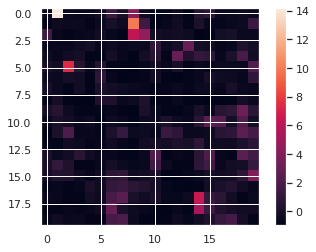

In [ ]:
plt.imshow(np.squeeze(field))
plt.colorbar()

In [ ]:
# simulator args
simulator_args = {'N': N, 'squeeze': False, 'pad': 2 }

In [ ]:
# LN field distribution
def _f_NL(α, β):
    return tfd.TransformedDistribution(
        distribution=tfd.MultivariateNormalTriL(
            loc=np.zeros((N**2,)),
            scale_tril=np.linalg.cholesky(ξ_G(β))),
        bijector=tfb.Chain([
            tfb.Scale(1. / np.expand_dims(α, (-1))), 
            tfb.Expm1(),
            tfb.AffineScalar(
                shift=-0.5 * np.expand_dims(α, -1)**2.,
                scale=np.expand_dims(α, -1))]))


# draw from the joint distribution
def simulator(rng, n, α, β,):
    dist = _f_NL(α, β)
    if n is not None:
        return dist.sample(n, seed=rng)
    else: 
        return dist.sample(seed=rng)


# simulator uses Florent's LN field simulator
# wrapper for IMNN and ABC sampler
def imnn_simulator(rng, θ, simulator_args=simulator_args):
    A,B = θ
    N = simulator_args['N']
    pad = simulator_args['pad']
    #noise = 0.01
    def fn(key, A, B):
        if simulator_args['squeeze']:
            return np.expand_dims(
                np.pad(
                    #simulator(key, None, A, B).reshape(N,N), 
                    LN.run_simulation(key, A, B),
                    [pad,pad],
                    ), 
                0)

        else:
            return (np.expand_dims(
                        np.expand_dims(
                            np.pad(
                                #simulator(key, None, A, B).reshape(N,N),
                                LN.run_simulation(key, A, B),
                                [pad,pad]
                                ),  
                            0), 
                0))

    if A.shape == B.shape:
        if len(A.shape) == 0:
            return fn(rng, A, B)
        else:
            keys = jax.random.split(rng, num=A.shape[0] + 1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(
                lambda key, A, B: imnn_simulator(key, (A,B), simulator_args=simulator_args)
            )(keys, A, B)
    else:
        if len(A.shape) > 0:
            keys = jax.random.split(rng, num=A.shape[0] + 1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(
                lambda key, A: imnn_simulator(key, (A,B), simulator_args=simulator_args)
            )(keys, A)
        elif len(B.shape) > 0:
            keys = jax.random.split(rng, num=B.shape[0])
            return jax.vmap(
                lambda key, B: imnn_simulator(key, (A,B), simulator_args=simulator_args)
            )(keys, B)
    

In [ ]:
pad = 2 #2**2
input_shape = (1,1, N+pad*2,N+pad*2)
print('input shape: ', input_shape)
θ_fid = np.array([0.95, 0.55], dtype=np.float32)


# IMNN params
n_s = 5000
n_d = 5000
λ = 100.0
ϵ = 0.1

n_params = 2
n_summaries = 2

input shape:  (1, 1, 24, 24)


# nn model stuff

In [ ]:
# define stax model
from jax.nn.initializers import normal
def InceptBlock2(filters, strides, do_5x5=True, do_3x3=True, 
                 padding="SAME", W_init=None):
    """InceptNet convolutional striding block.
    filters: tuple: (f1,f2,f3)
    filters1: for conv1x1
    filters2: for conv1x1,conv3x3
    filters3L for conv1x1,conv5x5"""
    
    filters1, filters2, filters3 = filters
    
    conv1x1 = stax.serial(stax.Conv(filters1, (1,1), strides, padding=padding, W_init=W_init))
    
    filters4 = filters2
    conv3x3 = stax.serial(stax.Conv(filters2, (1,1), strides=None, padding=padding, W_init=W_init),
                        stax.Conv(filters4, (3,3), strides, padding=padding, W_init=W_init))
                        
    filters5 = filters3
    conv5x5 = stax.serial(stax.Conv(filters3, (1,1), strides=None, padding=padding, W_init=W_init),
                         stax.Conv(filters5, (5,5), strides, padding=padding, W_init=W_init))

    maxpool = stax.serial(stax.MaxPool((3,3), padding=padding),
                         stax.Conv(filters4, (1,1), strides, padding=padding, W_init=W_init))
                            
    if do_3x3:
        if do_5x5:
            return stax.serial(
                  stax.FanOut(4),  # should num=3 or 2 here ?
                  stax.parallel(conv1x1, conv3x3, conv5x5, maxpool),
                  stax.FanInConcat(), 
                  stax.LeakyRelu)
        else:
            return stax.serial(
                  stax.FanOut(3),  # should num=3 or 2 here ?
                  stax.parallel(conv1x1, conv3x3, maxpool),
                  stax.FanInConcat(), 
                  stax.LeakyRelu)
            
    else:
        return stax.serial(
              stax.FanOut(2),  # should num=3 or 2 here ?
              stax.parallel(conv1x1, maxpool),
              stax.FanInConcat(), 
              stax.LeakyRelu)
    
    
def Reshape(newshape):
    """Layer function for a reshape layer."""
    init_fun = lambda rng, input_shape: (newshape,())
    apply_fun = lambda params, inputs, **kwargs: np.reshape(inputs,newshape)
    return init_fun, apply_fun


from jax.nn.initializers import glorot_normal, normal, ones, zeros


def LogLayer(a_init=ones, b_init=ones,
              c_init=ones, d_init=ones, C=3., scalar=True):
    """custom layer for log-normalizing field inputs"""
    _a_init = lambda rng,shape: a_init(rng, shape)
    _b_init = lambda rng,shape: b_init(rng, shape)
    _c_init = lambda rng,shape: c_init(rng, shape)
    _d_init = lambda rng,shape: d_init(rng, shape)
    
    def init_fun(rng, input_shape):
        
        if scalar:
            shape = ()
        else:
            shape = input_shape 
    
        k1, rng = jax.random.split(rng)
        k2, rng = jax.random.split(rng)
        k3, rng = jax.random.split(rng)
        k4, rng = jax.random.split(rng)
        a,b = _a_init(k1, shape), _b_init(k2, shape)
        c,d = _c_init(k3, shape)*C, _d_init(k4, shape)
        return input_shape, (a,b,c,d)

    def apply_fun(params, inputs, **kwargs):
        a,b,c,d = params
        
        return a * np.log(np.abs(b)*inputs + c) + d
    
    return init_fun, apply_fun



def AsinhLayer(a_init=ones, b_init=ones,
              c_init=ones, d_init=ones, scalar=True):
    """custom layer for Asinh-normalizing field inputs"""
    _a_init = lambda rng,shape: a_init(rng, shape)
    _b_init = lambda rng,shape: b_init(rng, shape)
    _c_init = lambda rng,shape: c_init(rng, shape)
    _d_init = lambda rng,shape: d_init(rng, shape)
    def init_fun(rng, input_shape):
        if scalar:
            shape = ()
        else:
            shape = input_shape 
        k1, rng = jax.random.split(rng)
        k2, rng = jax.random.split(rng)
        k3, rng = jax.random.split(rng)
        k4, rng = jax.random.split(rng)
        a,b = _a_init(k1, shape), _b_init(k2, shape)
        c,d = _c_init(k3, shape), _d_init(k4, shape)
        return input_shape, np.stack((a,b,c,d), 0)
    def apply_fun(params, inputs, **kwargs):
        a,b,c,d = params
        return a * np.arcsinh(b*inputs + c) + d
    return init_fun, apply_fun

def ScalarLayer(C=None, c_init=ones):
    """Layer construction function for a reshape layer."""
    
    if C is None:
        C = 1.0
    
    _c_init = lambda rng,shape: c_init(rng, shape)*C
    
    def init_fun(rng, input_shape):
        shape = input_shape
        k1, rng = jax.random.split(rng)
        constant = _c_init(k1, shape)
        return input_shape, (constant)

    def apply_fun(params, inputs, **kwargs):
        cnst = params
        return inputs*cnst
    
    
    return init_fun, apply_fun



# build model

In [ ]:
# build model
# build model
fs = 128

model = stax.serial(
        AsinhLayer(scalar=True),
        InceptBlock2((fs,fs,fs), strides=(1,1)),
        InceptBlock2((fs,fs,fs), strides=(2,2)),
        #InceptBlock2((fs,fs,fs), strides=(1,1)),
        InceptBlock2((fs,fs,fs), strides=(2,2)),
        #InceptBlock2((fs,fs,fs), strides=(1,1)),
        InceptBlock2((fs,fs,fs), strides=(2,2), do_5x5=False),
        #InceptBlock2((fs,fs,fs), strides=(1,1), do_5x5=False),
        InceptBlock2((fs,fs,fs), strides=(3,3), do_5x5=False, do_3x3=False),  # add in dense layers here ?
        stax.Dense(50),
        stax.LeakyRelu,
        stax.Dense(50),
        stax.LeakyRelu,
        stax.Dense(n_summaries),
        #stax.Conv(n_summaries, (1,1), strides=(1,1), padding="SAME"),
        stax.Flatten,
        Reshape((n_summaries,))
)



# # build model
# fs = 150

# model = stax.serial(
#         AsinhLayer(scalar=True),
#         # stax.Flatten,
#         # stax.Dense(400),
#         # stax.LeakyRelu,
#         # stax.Dense(400),
#         # stax.LeakyRelu,
#         # Reshape((1,1,20,20)),
#         #InceptBlock2((fs,fs,fs), strides=(1,1)),
#         InceptBlock2((fs,fs,fs), strides=(2,2)),
#         InceptBlock2((fs,fs,fs), strides=(2,2)),
#         InceptBlock2((fs,fs,fs), strides=(5,5), do_5x5=False),
#         #InceptBlock2((fs,fs,fs), strides=(2,2), do_5x5=False),
#         #InceptBlock2((fs,fs,fs), strides=(3,3), do_5x5=False, do_3x3=False),  # add in dense layers here ?
#         stax.Flatten,
#         stax.Dense(fs),
#         stax.LeakyRelu,
#         stax.Dense(fs),
#         stax.LeakyRelu,
#         stax.Dense(n_summaries),
#         stax.Flatten,
#         Reshape((n_summaries,))
# )

In [ ]:
rng, initial_model_key = jax.random.split(rng)
rng, fitting_key = jax.random.split(rng)

In [ ]:
optimiser = optimizers.adam(step_size=1e-3)

In [ ]:
# adam w learn rate decay
batch_size = 1
num_batches = 2000

optimiser = optimizers.adam(
    lambda t: np.select([t < batch_size*(num_batches//3),
                          t < batch_size*(2*num_batches//3),
                          t > batch_size*(2*num_batches//3)],
                         [1e-3, 3e-4, 1e-4]))

In [ ]:
rng, key = jax.random.split(rng)
IMNN = imnn.IMNN(
        n_s=2000,
        n_d=2000,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        model=model,
        optimiser=optimiser,
        key_or_state=key,
        simulator=lambda rng, θ: imnn_simulator(
            rng, θ, simulator_args={**simulator_args, **{"squeeze": False}}),
        #host=jax.devices()[0],
        #devices=[jax.devices()[0]],
        #n_per_device=1000
        )

`simulator` provided, using SimulatorIMNN


In [ ]:
%%time
rng, key = jax.random.split(rng)
IMNN.fit(λ=10., ϵ=0.1, rng=key, print_rate=None, min_iterations=7000, best=True)

CPU times: user 3h 21min 40s, sys: 9.5 s, total: 3h 21min 50s
Wall time: 3h 20min 53s


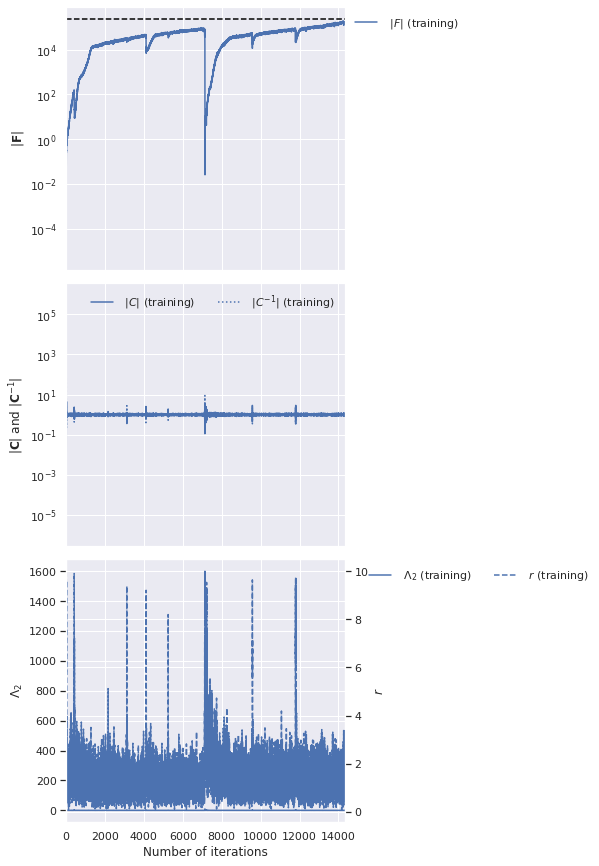

In [ ]:
ax = IMNN.plot(expected_detF=detF_expected)
ax[0].set_yscale('log')

In [ ]:
import cloudpickle as pickle
import os

def save_weights(IMNN, folder_name='./model', weights='final'):
    
    # create output directory
    if not os.path.exists(folder_name): 
        os.mkdir(folder_name)
    
    def pckl_me(obj, path):
        with open(path, 'wb') as file_pi:
            pickle.dump(obj, file_pi)
        file_pi.close()
        
    # save IMNN (optimiser) state:
    savestate = jax.experimental.optimizers.unpack_optimizer_state(IMNN.state)
    pckl_me(savestate, os.path.join(folder_name, 'IMNN_state'))
    
    # save weights
    if weights == 'final':
        np.save(os.path.join(folder_name, 'final_w'), IMNN.final_w)
    
    else:
        np.save(os.path.join(folder_name, 'best_w'), IMNN.best_w)
        
    # save initial weights
    np.save(os.path.join(folder_name, 'initial_w'), IMNN.initial_w)
        
    # save training history
    pckl_me(IMNN.history, os.path.join(folder_name, 'history'))
    
    # save important attributes as a dict
    imnn_attributes = {
        'n_s': IMNN.n_s,
        'n_d': IMNN.n_d,
        'input_shape': IMNN.input_shape,
        'n_params' : IMNN.n_params,            
        'n_summaries': IMNN.n_summaries,
        'θ_fid': IMNN.θ_fid,
        'F': IMNN.F,   
        'invF': IMNN.invF,
        'C': IMNN.C,
        'invC': IMNN.invC,
        'validate': IMNN.validate,
        'simulate': IMNN.simulate,
        
    }
    
    pckl_me(imnn_attributes, os.path.join(folder_name, 'IMNN_attributes'))
    
    print('saved weights and attributes to the file ', folder_name)
    
    
def load_weights(IMNN, folder_name='./model', weights='final', load_attributes=True):
    
    
    def unpckl_me(path):
        file = open(path, 'rb')
        return pickle.load(file)
    
    # load and assign weights
    if weights=='final':
        weights = np.load(os.path.join(folder_name, 'final_w.npy'),  allow_pickle=True)
        IMNN.final_w = weights
    else:
        weights = np.load(os.path.join(folder_name, 'best_w.npy'),  allow_pickle=True)
        IMNN.best_w = weights
        
    # re-pack and load the optimiser state
    loadstate = unpckl_me(os.path.join(folder_name, 'IMNN_state'))
    IMNN.state = jax.experimental.optimizers.pack_optimizer_state(loadstate)
    
    
    # load history
    IMNN.history = unpckl_me(os.path.join(folder_name, 'history'))
    
    # load important attributes
    if load_attributes:
        IMNN.intial_w =  np.load(os.path.join(folder_name, 'initial_w.npy'), allow_pickle=True)
        attributes = unpckl_me(os.path.join(folder_name, 'IMNN_attributes'))
        IMNN.θ_fid = attributes['θ_fid']
        IMNN.n_s = attributes['n_s']
        IMNN.n_d = attributes['n_d']
        IMNN.input_shape = attributes['input_shape']
        IMNN.F = attributes['F']
        IMNN.invF = attributes['invF']
        IMNN.C = attributes['C']
        IMNN.invC = attributes['invC']
        
    print('loaded IMNN with these attributes: ', attributes)
    

In [ ]:
save_weights(IMNN, folder_name='./big-LN-incept', weights='best')

saved weights and attributes to the file  ./big-LN-incept


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [ ]:
!zip -r /content/big-LN-incept.zip /content/big-LN-incept

from google.colab import files
files.download("/content/big-LN-incept.zip")

  adding: content/big-LN-incept/ (stored 0%)
  adding: content/big-LN-incept/final_w.npy (deflated 7%)
  adding: content/big-LN-incept/best_w.npy (deflated 7%)
  adding: content/big-LN-incept/IMNN_attributes (deflated 30%)
  adding: content/big-LN-incept/history (deflated 13%)
  adding: content/big-LN-incept/IMNN_state (deflated 38%)
  adding: content/big-LN-incept/initial_w.npy (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
np.linalg.det(IMNN.F) / detF_expected

DeviceArray(0.692845, dtype=float32)

# obtain target data from Florent's analysis

In [ ]:
!git clone https://github.com/florent-leclercq/correlations_vs_field.git

In [ ]:
dataid = 1 # for florent's sims as target data

In [ ]:
rng, key = jax.random.split(rng)
target = dict(
    f_NL=None,
    α=np.array(1.0),
    β=np.array(0.5))

dat = np.load("./correlations_vs_field/data/Sims20_05_10_80_80_500_80_1_123456.npy")
target['f_NL'] = dat[dataid]['field'].flatten()

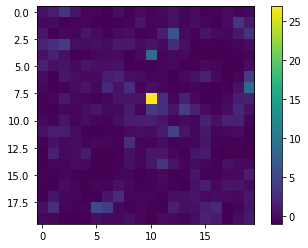

In [ ]:
plt.imshow(target["f_NL"].reshape((N, N)))
plt.colorbar()

In [ ]:
target['f_NL'].shape

(400,)

In [ ]:
# put data in the proper shape for IMNN 
θ_target = np.array([1.0, 0.5])
δ_target = np.expand_dims(np.expand_dims(np.expand_dims(np.pad(target["f_NL"].reshape((N, N)), [2,2]), 0), 0),0)
estimates = IMNN.get_estimate(target_data)

# priors

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

import tensorflow_probability.substrates.jax as tfpj
tfdj = tfpj.distributions
tfbj = tfpj.bijectors

import tensorflow.keras.backend as K

In [ ]:
# prior for sim draws in jax
prior = tfpj.distributions.Blockwise(
    [tfpj.distributions.Uniform(low=low, high=high)
     for low, high in zip([0.4, 0.2], [1.5, 0.8])])
prior.low = np.array([0.4, 0.2])
prior.high = np.array([1.5, 0.8])



# set up prior in non-jax tfp
samp_prior = tfp.distributions.Blockwise(
    [tfp.distributions.Uniform(low=low, high=high)
     for low, high in zip([0.4, 0.2], [1.5, 0.8])])
prior.low = np.array([0.4, 0.2])
prior.high = np.array([1.5, 0.8])

In [ ]:
GA = imnn.lfi.GaussianApproximation(
    parameter_estimates=estimates, 
    invF=np.expand_dims(np.linalg.inv(IMNN.F), 0), 
    prior=prior, 
    gridsize=100)

### initialize ABC

In [ ]:
ABC = imnn.lfi.ApproximateBayesianComputation(
    target_data=target_data,
    prior=prior,
    simulator=lambda rng, θ : imnn_simulator(rng, θ, simulator_args={**simulator_args, **{'squeeze':False}}),
    compressor=IMNN.get_estimate,
    gridsize=100, 
    F=np.expand_dims(IMNN.F, 0))

In [ ]:
from tqdm import trange
import numpy as onp

def affine_sample(log_prob, n_params, n_walkers, n_steps, walkers1, walkers2):
    
    # initialize current state
    current_state1 = tf.Variable(walkers1)
    current_state2 = tf.Variable(walkers2)
    

    # initial target log prob for the walkers (and set any nans to -inf)...
    logp_current1 = log_prob(current_state1)
    logp_current2 = log_prob(current_state2)
    logp_current1 = tf.where(tf.math.is_nan(logp_current1), tf.ones_like(logp_current1)*tf.math.log(0.), logp_current1)
    logp_current2 = tf.where(tf.math.is_nan(logp_current2), tf.ones_like(logp_current2)*tf.math.log(0.), logp_current2)

    # holder for the whole chain
    chain = [tf.concat([current_state1, current_state2], axis=0)]
    
    # MCMC loop
    with trange(1, n_steps) as t:
        for epoch in t:

            # first set of walkers:

            # proposals
            partners1 = tf.gather(current_state2, onp.random.randint(0, n_walkers, n_walkers))
            z1 = 0.5*(tf.random.uniform([n_walkers], minval=0, maxval=1)+1)**2
            proposed_state1 = partners1 + tf.transpose(z1*tf.transpose(current_state1 - partners1))
            

            # target log prob at proposed points
            logp_proposed1 = log_prob(proposed_state1)
            logp_proposed1 = tf.where(tf.math.is_nan(logp_proposed1), tf.ones_like(logp_proposed1)*tf.math.log(0.), logp_proposed1)

            # acceptance probability
            p_accept1 = tf.math.minimum(tf.ones(n_walkers), z1**(n_params-1)*tf.exp(logp_proposed1 - logp_current1) )

            # accept or not
            accept1_ = (tf.random.uniform([n_walkers], minval=0, maxval=1) <= p_accept1)
            accept1 = tf.cast(accept1_, tf.float32)

            # update the state
            current_state1 = tf.transpose( tf.transpose(current_state1)*(1-accept1) + tf.transpose(proposed_state1)*accept1)
            logp_current1 = tf.where(accept1_, logp_proposed1, logp_current1)

            # second set of walkers:

            # proposals
            partners2 = tf.gather(current_state1, onp.random.randint(0, n_walkers, n_walkers))
            z2 = 0.5*(tf.random.uniform([n_walkers], minval=0, maxval=1)+1)**2
            proposed_state2 = partners2 + tf.transpose(z2*tf.transpose(current_state2 - partners2))

            # target log prob at proposed points
            logp_proposed2 = log_prob(proposed_state2)
            logp_proposed2 = tf.where(tf.math.is_nan(logp_proposed2), tf.ones_like(logp_proposed2)*tf.math.log(0.), logp_proposed2)

            # acceptance probability
            p_accept2 = tf.math.minimum(tf.ones(n_walkers), z2**(n_params-1)*tf.exp(logp_proposed2 - logp_current2) )

            # accept or not
            accept2_ = (tf.random.uniform([n_walkers], minval=0, maxval=1) <= p_accept2)
            accept2 = tf.cast(accept2_, tf.float32)

            # update the state
            current_state2 = tf.transpose( tf.transpose(current_state2)*(1-accept2) + tf.transpose(proposed_state2)*accept2)
            logp_current2 = tf.where(accept2_, logp_proposed2, logp_current2)

            # append to chain
            chain.append(tf.concat([current_state1, current_state2], axis=0))

    # stack up the chain
    chain = tf.stack(chain, axis=0)
    
    return chain


In [ ]:
class ConditionalMaskedAutoregressiveFlow(tf.Module):
    def __init__(self, n_dimensions=None, n_conditionals=None, n_mades=1, n_hidden=[50,50], input_order="random",
    activation=tf.keras.layers.LeakyReLU(0.01), 
    all_layers=True,
    kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1e-5, seed=None), 
    bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1e-5, seed=None),
    kernel_regularizer=None, bias_regularizer=None, kernel_constraint=None,
    bias_constraint=None):
        super(ConditionalMaskedAutoregressiveFlow, self).__init__()
        # extract init parameters
        self.n_dimensions = n_dimensions
        self.n_conditionals = n_conditionals
        self.n_mades = n_mades
        # construct the base (normal) distribution
        self.base_distribution = tfd.MultivariateNormalDiag(loc=tf.zeros(self.n_dimensions), scale_diag=tf.ones(self.n_dimensions))
        # put the conditional inputs to all layers, or just the first layer?
        if all_layers == True:
            all_layers = "all_layers"
        else:
            all_layers = "first_layer"
        # construct stack of conditional MADEs
        self.MADEs = [tfb.AutoregressiveNetwork(
                        params=2,
                        hidden_units=n_hidden,
                        activation=activation,
                        event_shape=[n_dimensions],
                        conditional=True,
                        conditional_event_shape=[n_conditionals],
                        conditional_input_layers=all_layers,
                        input_order=input_order,
                        kernel_initializer=kernel_initializer,
                        bias_initializer=bias_initializer,
                        kernel_regularizer=kernel_regularizer,
                        bias_regularizer=bias_regularizer,
                        kernel_constraint=kernel_constraint,
                        bias_constraint=bias_constraint,
                        name="MADE_{}".format(i)) for i in range(n_mades)]
    # bijector for x | y (chain the conditional MADEs together)
    def bijector(self, y):
        # start with an empty bijector
        MAF = tfb.Identity() 
        # pass through the MADE layers (passing conditional inputs each time)
        for i in range(self.n_mades):
            MAF = tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=lambda x: self.MADEs[i](x, conditional_input=y))(MAF)
        return MAF
    # construct distribution P(x | y)
    def __call__(self, y):
        return tfd.TransformedDistribution(
            self.base_distribution,
            bijector=self.bijector(y))
    # log probability ln P(x | y)
    def log_prob(self, x, y):
        return self.__call__(y).log_prob(x)
    # sample n samples from P(x | y)
    def sample(self, n, y):
        # base samples
        base_samples = self.base_distribution.sample(n)
        # biject the samples
        return self.bijector(y).forward(base_samples)

In [ ]:
num_models = 2
cmaf_models = [ConditionalMaskedAutoregressiveFlow(n_dimensions=2, 
                                                   n_conditionals=2, n_hidden=[50,50,50]) for i in range(num_models)]

cmaf_models += [ConditionalMaskedAutoregressiveFlow(n_dimensions=2, 
                                                    n_conditionals=2, n_hidden=[50,50]) for i in range(2)]

In [ ]:
maf_optimizers = [tf.keras.optimizers.Adam(learning_rate=1e-3) for i in range(len(cmaf_models))]

In [ ]:
@tf.function
def train_step(x, y):
    _ls = []
    for m in range(len(cmaf_models)):
        with tf.GradientTape() as tape:
            _l = K.mean(-cmaf_models[m].log_prob(x, y) - samp_prior.log_prob(y))
            _ls.append(_l)
        
        grads = tape.gradient(_l, cmaf_models[m].trainable_variables)
        maf_optimizers[m].apply_gradients(zip(grads, cmaf_models[m].trainable_variables))
        #train_acc_metric.update_state(y, logits)
    return _ls

@tf.function
def val_step(x, y):
    _val_l = []
    for m in range(len(cmaf_models)):
        _val_l.append(K.mean(-cmaf_models[m].log_prob(x, y) - samp_prior.log_prob(y)))
    return _val_l

@tf.function
def loss(x, y):
    return K.mean(-cmaf_model.log_prob(x, y))

In [ ]:
# create dataset for this demo

num_sims = 1000

keys = jax.random.split(rng, num=num_sims)

def get_params_summaries(key, n_samples, ϑ_samp):
    keys = np.array(jax.random.split(key, num=n_samples))
    sim = lambda rng, θ: imnn_simulator(
            rng, θ, simulator_args={
                **simulator_args, 
                **{"squeeze": False}})
    d = jax.vmap(sim)(keys, ϑ_samp)
    
    t = IMNN.get_estimate(d)
    
    t1 = t.flatten()[~np.isnan(t.flatten())]
    ϑ_samp = ϑ_samp.flatten()[~np.isnan(t.flatten())]
    
    # scale all summaries
    t1 = t1.reshape((len(t1)//2, 2))
    
    #_tstd = np.std(t1, axis=0)
    #_tmu = np.mean(t1, axis=0)
    
    #t1 = (t1 - _tmu) / _tstd
    
    # return x,y; e.g. t and ϑ (conditional)
    # learn p(x | y) = p(t | ϑ)
    return t1, ϑ_samp.reshape(len(ϑ_samp)//2, 2) #, _tmu, _tstd


def get_dataset(data, batch_size=20, buffer_size=1000, split=0.75):
    x,y = data


    idx = int(len(x)*split)
    x_train = x[:idx]
    y_train = y[:idx]  
    x_val = x[idx:]
    y_val = y[idx:]

    # Prepare the training dataset.
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=buffer_size).batch(batch_size)

    # Prepare the validation dataset.
    val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val_dataset = val_dataset.batch(batch_size)
    
    return train_dataset, val_dataset

def proposal_distribution(prior, MAF):
    """return geometric mean of proposal distribution"""
    
    
    

In [ ]:
n_samples = 1000
batch_size = 100
buffer_size = n_samples
key1,key2 = jax.random.split(rng)

ϑ_samp = prior.sample(sample_shape=(n_samples,), seed=key1)
ts, ϑ_samp = get_params_summaries(key2, n_samples, ϑ_samp)
data = (ts, ϑ_samp)

In [ ]:
train_dataset, val_dataset = get_dataset(data, batch_size=batch_size, buffer_size=buffer_size)

In [ ]:
import time
from tqdm import tqdm

epochs = 2000

train_losses = []
val_losses = []


for epoch in tqdm(range(epochs)):
    #print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()


    # shuffle training data anew every 100th epoch
    if epoch % 100 == 0:
        train_dataset = train_dataset.shuffle(buffer_size=buffer_size)


    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        loss_values = np.array(train_step(x_batch_train, y_batch_train))

    train_losses.append(loss_values)


    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        val_loss = np.array(val_step(x_batch_val, y_batch_val))

    val_losses.append(val_loss)

100%|██████████| 2000/2000 [00:57<00:00, 34.70it/s]


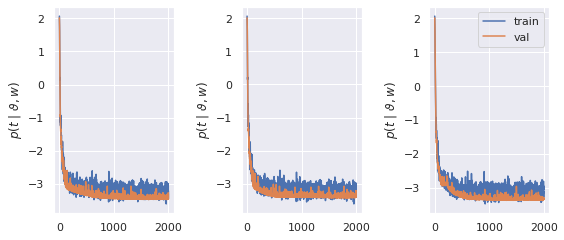

In [ ]:
import seaborn as sns
%matplotlib inline

sns.set_theme()
plt.figure(figsize=(8,3.5))
plt.subplot(131)
plt.plot(np.array(train_losses).T[0], label='train')
plt.plot(np.array(val_losses).T[0], label='val')
plt.ylabel(r'$p(t\ |\ \vartheta, w)$')

plt.subplot(132)
plt.plot(np.array(train_losses).T[1], label='train')
plt.plot(np.array(val_losses).T[1], label='val')
plt.ylabel(r'$p(t\ |\ \vartheta, w)$')

plt.subplot(133)
plt.plot(np.array(train_losses).T[4], label='train')
plt.plot(np.array(val_losses).T[4], label='val')
plt.ylabel(r'$p(t\ |\ \vartheta, w)$')
plt.legend()

plt.tight_layout()
plt.show()

100%|██████████| 1999/1999 [00:06<00:00, 295.60it/s]


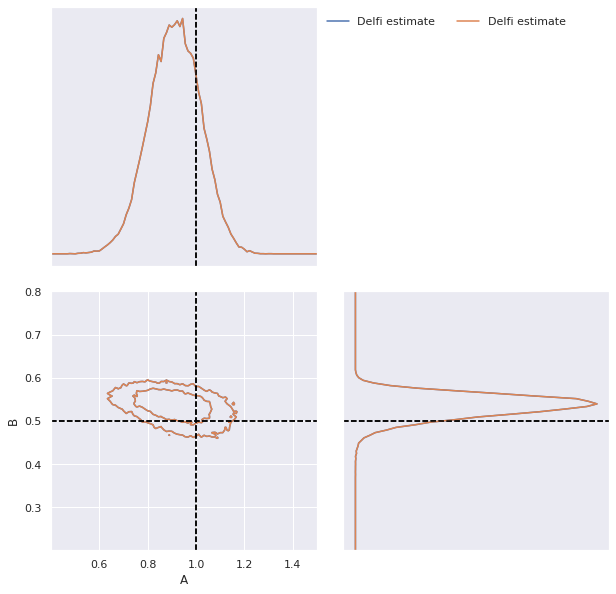

In [ ]:
# get summaries for observed data from IMNN
# δ_target is the 20x20 simulation
estimates = IMNN.get_estimate(δ_target)#IMNN.get_estimate(np.expand_dims(δ_target, (0, 1, 2)))


# define cmaf model log prob with prior defined above
@tf.function
def my_log_prob(y, x=estimates):
    
    # here all cmafs are trained to draw from p(x|y) <=> p(t|ϑ)
    # take the mean of the data likelihood p(x|y) over all cmafs
    _like = cmaf_models[0].log_prob(x,y)

    _prior = samp_prior.log_prob(x)
    
    return _like + _prior



# sample using affine
n_steps = 2000
n_walkers = 500
burnin_steps = 1800
n_params = 2

# initialize walkers...
walkers1 = tf.random.normal([n_walkers, 2], 0.5, 0.5)
walkers2 = tf.random.normal([n_walkers, 2], 0.5, 0.5)

# walkers1 = tf.random.uniform([n_walkers, 2], 0.1, 1.25)
# walkers2 = tf.random.uniform([n_walkers, 2], 0.1, 1.25)

chain = affine_sample(my_log_prob, n_params, n_walkers, n_steps, walkers1, walkers2)

skip = 4

post = np.stack([chain.numpy()[burnin_steps::skip,:,0].flatten(), chain.numpy()[burnin_steps::skip,:,1].flatten()], axis=-1)

# make ABC object for the marginal plot
_ABC = imnn.lfi.ApproximateBayesianComputation(
    target_data=δ_target,
    prior=prior,
    simulator=lambda rng, θ: simulator(rng, θ, simulator_args={**simulator_args, **{'squeeze':False}}),
    compressor=IMNN.get_estimate,
    gridsize=100, 
    F=np.expand_dims(IMNN.F, 0))

margs = _ABC.get_marginals(accepted_parameters = [np.array(post)], smoothing=None, gridsize=400)


MAF = imnn.lfi.LikelihoodFreeInference(
    prior=prior,
    gridsize=100)


MAF.n_targets=2
MAF.put_marginals(
                margs[1][0]);

MAF.marginal_plot(
    known=θ_target,          
    label="Delfi estimate",           
    axis_labels=["A", "B"]);

# next sample from maf post and re-train

In [ ]:
n_samples = 1000
key1,key2 = jax.random.split(rng)

idx = np.arange(len(post))
ϑ_samp = post[45000:][onp.random.choice(idx, size=n_samples)]

# ensure not < 0
idx = np.where(ϑ_samp > 0)[0]
ϑ_samp = ϑ_samp[idx]
n_samples = len(ϑ_samp)

ts, ϑ_samp = get_params_summaries(key2, n_samples, ϑ_samp)

new_data = (ts, ϑ_samp)

# this should shuffle the dataset 
new_train_dataset, new_val_dataset = get_dataset(new_data, batch_size=batch_size, buffer_size=len(new_data[0]))

# concatenate datasets
train_dataset = train_dataset.concatenate(new_train_dataset)
#val_dataset = val_dataset.concatenate(new_val_dataset)

In [ ]:
epochs = 1000

train_losses = []
val_losses = []


for epoch in tqdm(range(epochs)):
    start_time = time.time()


    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        loss_values = np.array(train_step(x_batch_train, y_batch_train))

    train_losses.append(loss_values)


    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        val_loss = np.array(val_step(x_batch_val, y_batch_val))

    val_losses.append(val_loss)

100%|██████████| 1000/1000 [01:23<00:00, 11.99it/s]


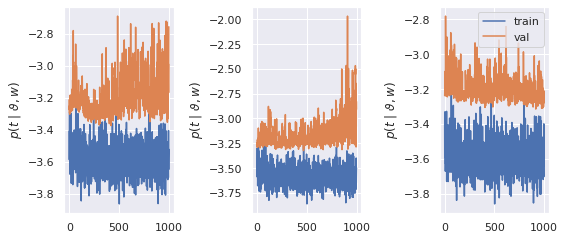

In [ ]:
plt.figure(figsize=(8,3.5))
plt.subplot(131)
plt.plot(np.array(train_losses).T[0], label='train')
plt.plot(np.array(val_losses).T[0], label='val')
plt.ylabel(r'$p(t\ |\ \vartheta, w)$')

plt.subplot(132)
plt.plot(np.array(train_losses).T[1], label='train')
plt.plot(np.array(val_losses).T[1], label='val')
plt.ylabel(r'$p(t\ |\ \vartheta, w)$')

plt.subplot(133)
plt.plot(np.array(train_losses).T[4], label='train')
plt.plot(np.array(val_losses).T[4], label='val')
plt.ylabel(r'$p(t\ |\ \vartheta, w)$')
plt.legend()

plt.tight_layout()
plt.show()

100%|██████████| 1999/1999 [00:06<00:00, 314.54it/s]


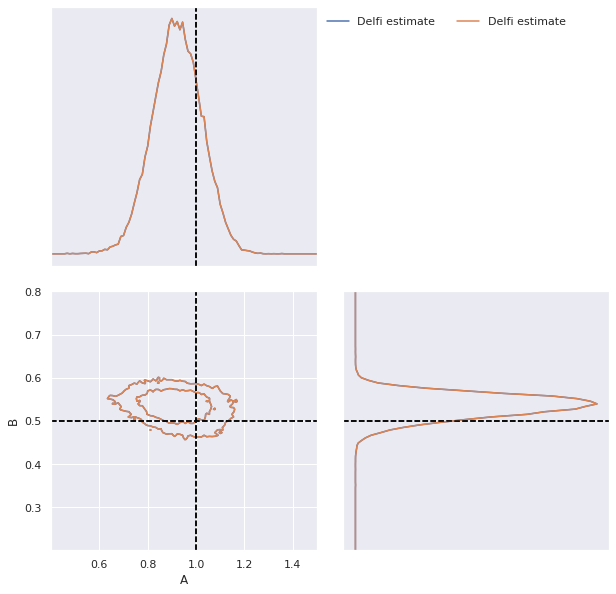

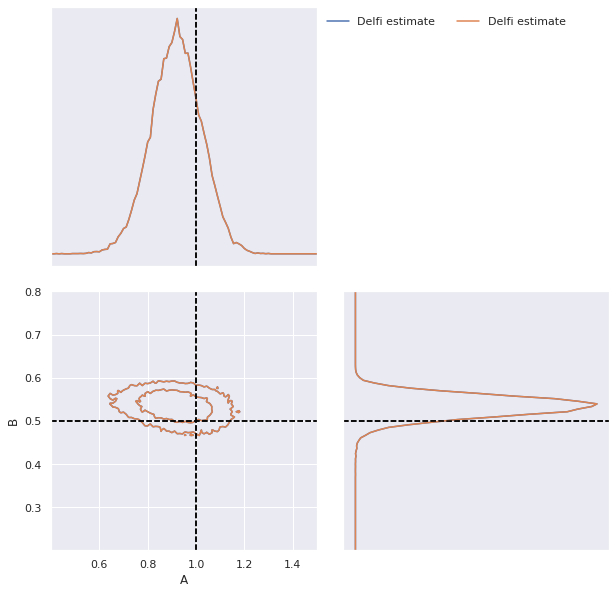

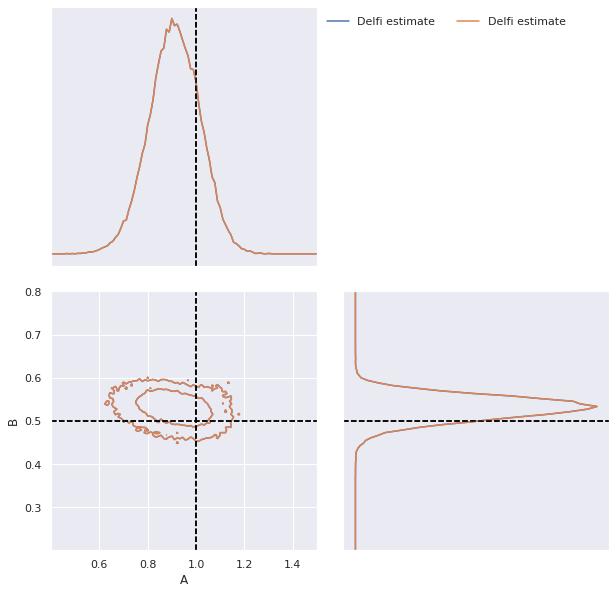

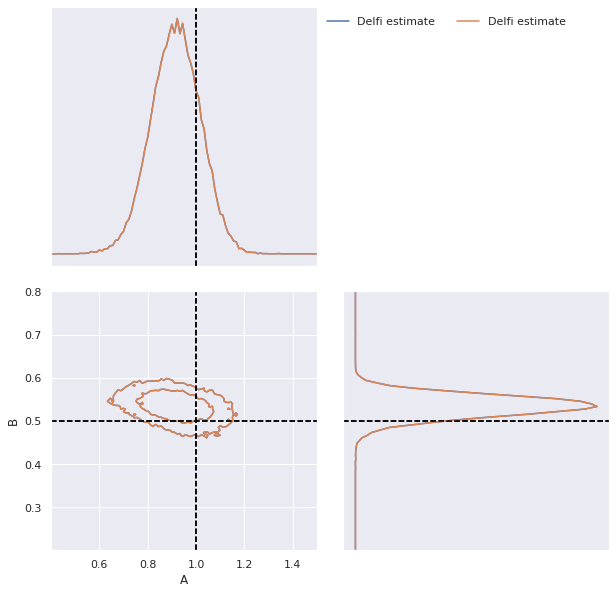

In [ ]:
# get summaries for observed data from IMNN
# δ_target is the 128x128 simulation


# do for each model
MAFs = []

for m,cmaf_model in enumerate(cmaf_models):

    @tf.function
    def my_log_prob(y, x=estimates):

        # here all cmafs are trained to draw from p(x|y) <=> p(t|ϑ)
        # take the mean of the data likelihood p(x|y) over all cmafs
        _like = cmaf_models[m].log_prob(x,y)
        _prior = samp_prior.log_prob(y)

        return _like + _prior

    # sample using affine
    n_steps = 2000
    n_walkers = 500
    burnin_steps = 1800
    n_params = 2

    # initialize walkers...
    walkers1 = tf.random.normal([n_walkers, 2], 0.5, 0.5)
    walkers2 = tf.random.normal([n_walkers, 2], 0.5, 0.5)

    # walkers1 = tf.random.uniform([n_walkers, 2], 0.1, 1.25)
    # walkers2 = tf.random.uniform([n_walkers, 2], 0.1, 1.25)

    chain = affine_sample(my_log_prob, n_params, n_walkers, n_steps, walkers1, walkers2)

    skip = 4

    post = np.stack([chain.numpy()[burnin_steps::skip,:,0].flatten(), chain.numpy()[burnin_steps::skip,:,1].flatten()], axis=-1)

    margs = ABC.get_marginals(accepted_parameters = [np.array(post)], smoothing=None, gridsize=400)


    _MAF = imnn.lfi.LikelihoodFreeInference(
        prior=prior,
        gridsize=100)


    _MAF.n_targets=2
    _MAF.put_marginals(
                    margs[1][0]);
    
    MAFs.append(_MAF)

    _MAF.marginal_plot(
        known=θ_target,          
        label="Delfi estimate",           
        axis_labels=["A", "B"]);

In [ ]:
%%time
rng, key = jax.random.split(rng)
ABC(ϵ=0.1, rng=key, n_samples=10000, min_accepted=500, 
    smoothing=1., max_iterations=2000);

[501] accepted in last  500 iterations  (5000000 simulations done).
CPU times: user 2min 18s, sys: 1.37 s, total: 2min 20s
Wall time: 2min 22s


(<imnn.utils.container.container at 0x154f386f3df0>,
 <imnn.utils.container.container at 0x154f48286130>)

In [ ]:
#np.save('./marginals/abc_distances', ABC.distances.accepted)

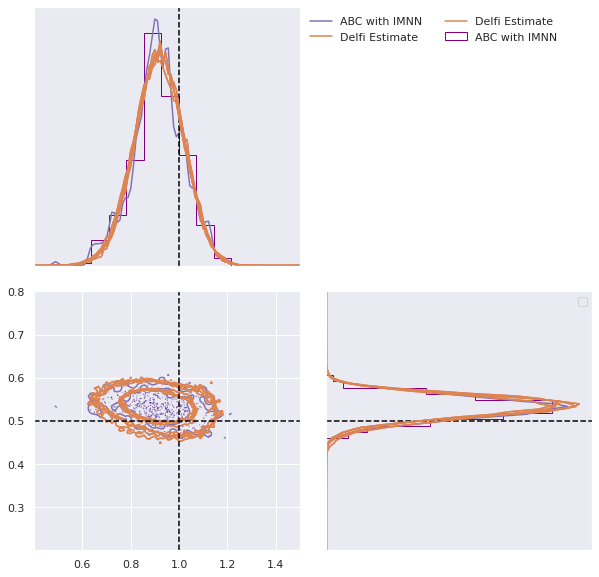

In [ ]:
# ax = GA.marginal_plot(
#     known=np.array([1.0, 0.5]),          
#     label="Gaussian approximation",         
#     axis_labels=[r"$\alpha$", r"$\beta$"],
#     colours="C1")

# ABC contour plots
ax = ABC.marginal_plot(ax=None, colours='C4', label='ABC with IMNN', known=θ_target)

# ABC scatter plots
ax[0,0].hist(ABC.parameters.accepted[0][:, 0], color='purple', histtype='step', density=True, label='ABC with IMNN')
ax[1,0].scatter(ABC.parameters.accepted[0][:, 0], ABC.parameters.accepted[0][:, 1], s=8, alpha=0.6,
                c=np.log(ABC.distances.accepted[0]), cmap='Purples', edgecolors=None, linewidths=0, marker='.')

ax[1,1].hist(ABC.parameters.accepted[0][:, 1], color='purple', 
             histtype='step', density=True, orientation='horizontal')



for m,_MAF in enumerate(MAFs):
    if m == 0:
        label = 'Delfi Estimate'
    else:
        label=None
        
    _MAF.marginal_plot(
        ax=ax,
        label=label,
        colours="C1", linestyle='solid');


plt.savefig('/mnt/home/tmakinen/repositories/field-plots/LN_delfi_vs_abc.png', dpi=800)
plt.legend()
plt.show()


In [ ]:
# params for GA contour
    row=1
    column=0
    target=0
    levels=[0.68, 0.95]
    all_margs = [GA.marginals for GA in [GA_1, GA_new]]
    alphas = [0.75, 1.0]
    linestyles = [':', 'solid']
    GA_labels = ['initial GA', 'final GA']
    ga_handles = []
    
    for m,margs in enumerate(all_margs):
        cs = ax[1,t].contour(
                                ranges[column],
                                ranges[row],
                                margs[row][column][target].T,
                                colors='#00c133',
                                linestyles=linestyles[m],
                                levels=GA_new.get_levels(
                                    margs[row][column][target],
                                    [ranges[column], ranges[row]],
                                    levels=levels), alpha=alphas[m],
        )
        # proxy for legend
        _ga, = ax[1,t].plot(-1,2, color='#00c133', 
                     linestyle=linestyles[m], 
                     alpha=alphas[m],label=GA_labels[m])
        
        ga_handles.append(_ga)

In [ ]:
ranges = ABC.ranges

In [ ]:
# save ABC marginals
np.save('./marginals/abc_ranges.npy', ranges)

In [ ]:
row=1
column=0
target=0
levels=[0.68, 0.95, 0.99]
margs = ABC.marginals

abc_2d_marg = ABC.marginals[row][column][target]

abc_levels = ABC.get_levels(margs[row][column][target],
                                    [ranges[column], ranges[row]], levels=levels)

maf_2d_margs = []
maf_levels = []

for i,m in enumerate(MAFs):

    maf_2d_margs.append(m.marginals[row][column][target])

    maf_levels.append(m.get_levels(margs[row][column][target],
                                        [ranges[column], ranges[row]], levels=levels))


In [ ]:
abc_levels

[DeviceArray(5.15118, dtype=float32),
 DeviceArray(5.15123, dtype=float32),
 DeviceArray(25.75615, dtype=float32)]

In [ ]:
np.save('./marginals/abc_2d_marginal_field_%d.npy'%(dataid), abc_2d_marg)
np.save('./marginals/abc_2d_marginal_field_levels_%d.npy'%(dataid), abc_levels)

In [ ]:
for i,m in enumerate(maf_2d_margs):
    np.save('./marginals/maf_%d_2d_marginal_field_%d.npy'%(i+1, dataid), maf_2d_margs[i])
    np.save('./marginals/maf_%d_2d_marginal_field_levels_%d.npy'%(i + 1, dataid), maf_levels[i])

In [ ]:
np.save('./marginals/abc_marginal_field_%d.npy'%(dataid), ABC.parameters.accepted)

In [ ]:
class ConditionalMaskedAutoregressiveFlow(tf.Module):
    def __init__(self, n_dimensions=None, n_conditionals=None, n_mades=1, n_hidden=[50,50], input_order="random",
    activation=tf.keras.layers.LeakyReLU(0.01), 
    all_layers=True,
    kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1e-5, seed=None), 
    bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1e-5, seed=None),
    kernel_regularizer=None, bias_regularizer=None, kernel_constraint=None,
    bias_constraint=None):
        # extract init parameters
        self.n_dimensions = n_dimensions
        self.n_conditionals = n_conditionals
        self.n_mades = n_mades
        # construct the base (normal) distribution
        self.base_distribution = tfd.MultivariateNormalDiag(loc=tf.zeros(self.n_dimensions), scale_diag=tf.ones(self.n_dimensions))
        # put the conditional inputs to all layers, or just the first layer?
        if all_layers == True:
            all_layers = "all_layers"
        else:
            all_layers = "first_layer"
        # construct stack of conditional MADEs
        self.MADEs = [tfb.AutoregressiveNetwork(
                        params=2,
                        hidden_units=n_hidden,
                        activation=activation,
                        event_shape=[n_dimensions],
                        conditional=True,
                        conditional_event_shape=[n_conditionals],
                        conditional_input_layers=all_layers,
                        input_order=input_order,
                        kernel_initializer=kernel_initializer,
                        bias_initializer=bias_initializer,
                        kernel_regularizer=kernel_regularizer,
                        bias_regularizer=bias_regularizer,
                        kernel_constraint=kernel_constraint,
                        bias_constraint=bias_constraint,
                        name="MADE_{}".format(i)) for i in range(n_mades)]
    # bijector for x | y (chain the conditional MADEs together)
    def bijector(self, y):
        # start with an empty bijector
        MAF = tfb.Identity() 
        # pass through the MADE layers (passing conditional inputs each time)
        for i in range(self.n_mades):
            MAF = tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=lambda x: self.MADEs[i](x, conditional_input=y))(MAF)
        return MAF
    # construct distribution P(x | y)
    def __call__(self, y):
        return tfd.TransformedDistribution(
            self.base_distribution,
            bijector=self.bijector(y))
    # log probability ln P(x | y)
    def log_prob(self, x, y):
        return self.__call__(y).log_prob(x)
    # sample n samples from P(x | y)
    def sample(self, n, y):
        # base samples
        base_samples = self.base_distribution.sample(n)
        # biject the samples
        return self.bijector(y).forward(base_samples)